In [39]:
from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.cit import chisq, fisherz, kci, gsq
from causallearn.utils.GraphUtils import GraphUtils
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import io

In [24]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=["NY"], download=True)
features, labels, _ = ACSIncome.df_to_numpy(data)

## Features

- AGEP (Age):
    - 0-99 int
    - 0 (less than a year old)
- COW (Class of worker):
    - NA
    - 1: Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions
    - 2: Employee of a private not-for-profit, tax-exempt, or charitable organization
    - 3: Local government employee (city, county, etc.)
    - 4: State government employee
    - 5: Federal government employee
    - 6: Self-employed in own not incorporated business, professional practice, or farm
    - 7: Self-employed in own incorporated business, professional practice or farm
    - 8: Working without pay in family business or farm
    - 9: Unemployed and last worked 5 years ago or earlier or never worked)
- SCHL: (Educational Attainment):
    - N/A (less than 3 years old) – 1: No schooling completed – 2: Nursery school/preschool – 3: Kindergarten
    - 4: Grade 1
    - 5: Grade 2
    - 6: Grade 3
    - 7: Grade 4
    - 8: Grade 5
    - 9: Grade 6
    - 10: Grade 7
    - 11: Grade 8
    - 12: Grade 9
    - 13: Grade 10
    - 14: Grade 11
    - 15: 12th Grade - no diploma
    - 16: Regular high school diploma
    - 17: GED or alternative credential
    - 18: Some college but less than 1 year
    - 19: 1 or more years of college credit but no degree – 20: Associate’s degree
    - 21: Bachelor’s degree
    - 22: Master’s degree
    - 23: Professional degree beyond a bachelor’s degree – 24: Doctorate degree
- MAR (Marital Status):
    - 1: Married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married or under 15 years old
- OCCP (Occupation): Refer to ACS PUMS for list
- POBP (Place of birth): Refer to ACS PUMS for list
- RELP (Relationship):
    - 0: Reference person
    - 1: Husband/wife
    - 2: Biological son or daughter
    - 3: Adopted son or daughter – 4: Stepson or stepdaughter – 5: Brother or sister
    - 6: Father or mother
    - 7: Grandchild
    - 8: Parent-in-law
    - 9: Son-in-law or daughter-in-law
    - 10: Other relative
    - 11: Roomer or boarder
    - 12: Housemate or roommate
    - 13: Unmarried partner
    - 14: Foster child
    - 15: Other nonrelative
    - 16: Institutionalized group quarters population
    - 17: Noninstitutionalized group quarters population
- WKHP (Usual hours worked per week past 12 months):
    - NA (less than 16 years old / did not work during the past 12 months)
    - 1-98 (int): usual hours worked
    - 99: 99 or more usual hours
- SEX (Sex): Range of values:
    - 1: Male
    - 2: Female
- RAC1P:
    - 1: White alone
    - 2: Black or African American alone
    - 3: American Indian alone
    - 4: Alaska Native alone
    - 5: American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races
    - 6: Asian alone
    - 7: Native Hawaiian and Other Pacific Islander alone
    - 8: Some Other Race alone
    - 9: Two or More Races





In [25]:
data_cat = np.c_[features, labels]
feats = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P', 'INCOME']
df = pd.DataFrame(data_cat, columns=feats)

In [26]:
# keep only certain features for modeling (as per Binkytė-Sadauskienė et al.)
df = df[["AGEP", "COW", "SCHL", "MAR", "WKHP", "SEX", "INCOME"]]

### PC Algorithm

In [28]:
# get graph without background knowledge
cg = pc(df.values, alpha=0.05, indep_test = gsq)


  0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
nodes = cg.G.get_nodes()
node_names = ["age", "workclass", "education", "marital", "hours", "sex", "income"]
nodes_dict = {}
for name, node in zip(node_names, nodes):
    nodes_dict[name] = node

In [36]:
# define tiers
bk = BackgroundKnowledge() \
    .add_node_to_tier(nodes_dict['age'], 1) \
    .add_node_to_tier(nodes_dict['sex'], 1) \
    .add_node_to_tier(nodes_dict['education'], 2) \
    .add_node_to_tier(nodes_dict['marital'], 2) \
    .add_node_to_tier(nodes_dict['workclass'], 3) \
    .add_node_to_tier(nodes_dict['hours'], 3) \
    .add_node_to_tier(nodes_dict['income'], 3)

# update graph with background knowledge
cg_with_bk = pc(df.values, alpha=0.05, indep_test = gsq, background_knowledge=bk)

  0%|          | 0/7 [00:00<?, ?it/s]

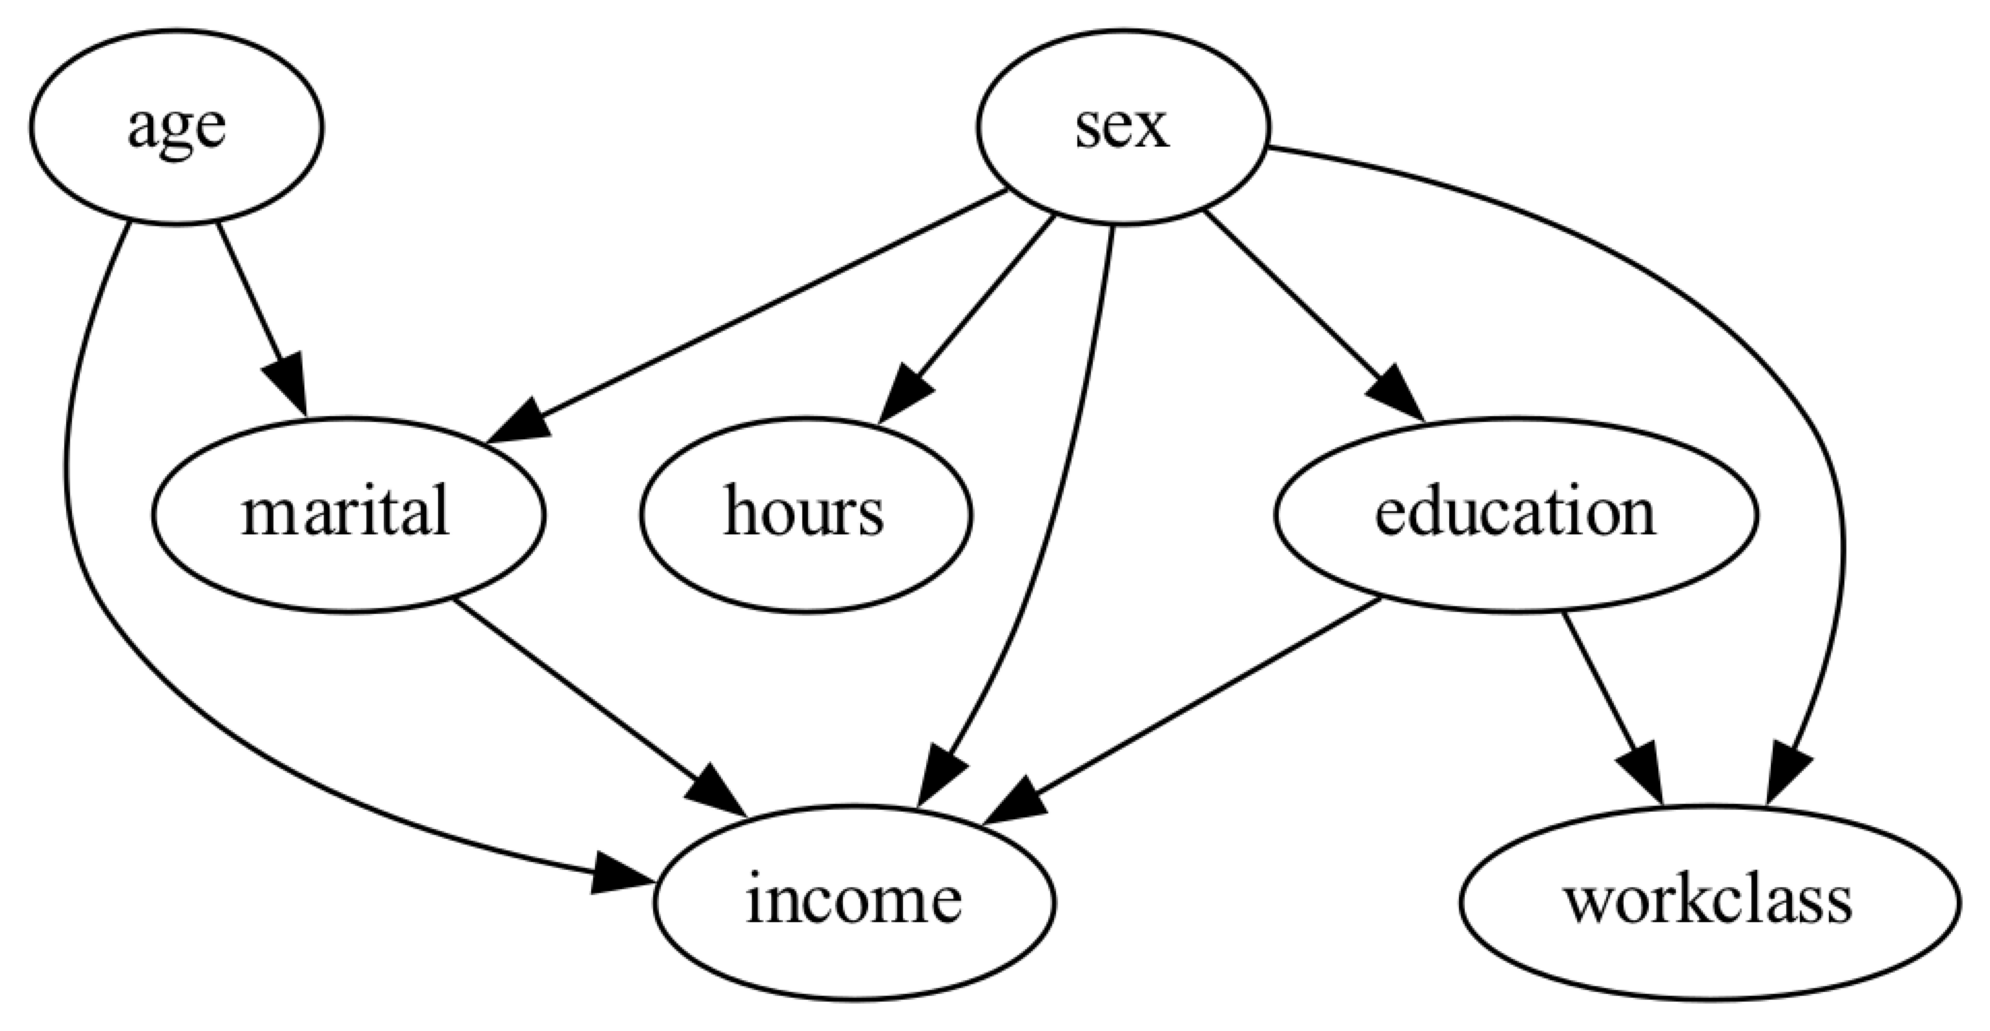

In [37]:
# visualization using pydot
cg_with_bk.draw_pydot_graph(labels = ["age", "workclass", "education", "marital", "hours", "sex", "income"])

# save causal graph
pyd = GraphUtils.to_pydot(cg_with_bk.G, labels = ["age", "workclass", "education", "marital", "hours", "sex", "income"])
pyd.write_png('pc_causal_graph.png')

### FCI Algorithm

In [43]:
# get graph without background knowledge
G, edges = fci(df.values, gsq, 0.05, verbose=False)

Starting Fast Adjacency Search.


  0%|          | 0/7 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.


In [45]:
nodes = G.get_nodes()
node_names = ["age", "workclass", "education", "marital", "hours", "sex", "income"]
nodes_dict = {}
for name, node in zip(node_names, nodes):
    nodes_dict[name] = node

In [49]:
# define tiers
bk = BackgroundKnowledge() \
    .add_node_to_tier(nodes_dict['age'], 1) \
    .add_node_to_tier(nodes_dict['sex'], 1) \
    .add_node_to_tier(nodes_dict['education'], 2) \
    .add_node_to_tier(nodes_dict['marital'], 2) \
    .add_node_to_tier(nodes_dict['workclass'], 3) \
    .add_node_to_tier(nodes_dict['hours'], 3) \
    .add_node_to_tier(nodes_dict['income'], 3)

# update graph with background knowledge
G_with_bk, edges = fci(df.values, alpha=0.05, indep_test = gsq, background_knowledge=bk)

Starting Fast Adjacency Search.


  0%|          | 0/7 [00:00<?, ?it/s]

X1 --- X6 because it was forbidden by background background_knowledge.
X2 --- X7 because it was forbidden by background background_knowledge.
X3 --- X4 because it was forbidden by background background_knowledge.
X5 --- X7 because it was forbidden by background background_knowledge.
Finishing Fast Adjacency Search.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X4
Orienting edge (Knowledge): X1 --> X5
Orienting edge (Knowledge): X1 --> X7
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X4 --> X2
Orienting edge (Knowledge): X6 --> X2
Orienting edge (Knowledge): X3 --> X5
Orienting edge (Knowledge): X6 --> X3
Orienting edge (Knowledge): X3 --> X7
Orienting edge (Knowledge): X4 --> X5
Orienting edge (Knowledge): X6 --> X4
Orienting edge (Knowledge): X4 --> X7
Orienting edge (Knowledge): X6 --> X5
Orienting edge (Knowledge): X6 --> X7
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2

In [51]:
fci_pdy = GraphUtils.to_pydot(G_with_bk, labels = ["age", "workclass", "education", "marital", "hours", "sex", "income"])

# save the causal graph
fci_pdy.write_png("fci_causal_graph.png")

### GES Algorithm

[[ 0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
[[ 0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0]]
[[ 0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  0 -1  0  0]]
[[ 0  0  0 -1  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 1  0  1  0 -1  0  0]]
[[ 0 -1  0 -1  0  0 -1]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0]
 [ 1  0  1  0 -1  0  0]]
[[ 0 -1  0 -1  0  0 -1]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  1]
 [ 0  0  0  0  1  0  0]
 [ 1  0  1 

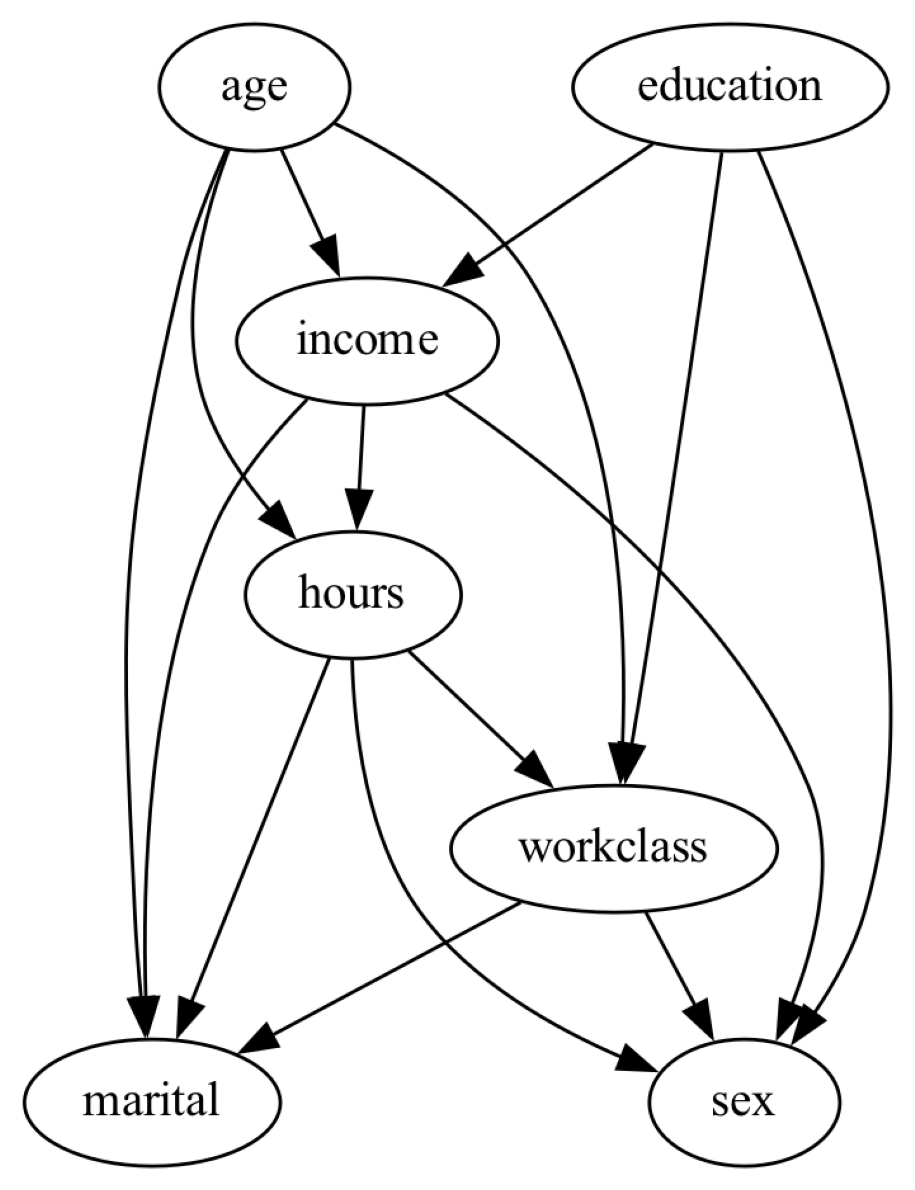

In [52]:
Record = ges(df.values)

pyd = GraphUtils.to_pydot(Record['G'], labels = ["age", "workclass", "education", "marital", "hours", "sex", "income"])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.savefig("ges_causal_graph.png", dpi=400)